<a href="https://colab.research.google.com/github/tylerganter/deep-practice/blob/master/dlwp/dlwp_3_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning with Python
## 3.5 Classifying news wires: a multiclass classification example

## Setup / Config

In [1]:
!pip uninstall tensorflow-gpu
!pip install tensorflow-gpu

     |████████████████████████████████| 421.8MB 40kB/s 
     |████████████████████████████████| 450kB 61.2MB/s 
     |████████████████████████████████| 3.8MB 57.2MB/s 
     |████████████████████████████████| 81kB 14.1MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.1.0 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorboard 2.1.0 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.11.0 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled goo

In [0]:
import json
import os
import psutil
import random
import time

from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.datasets import reuters
from tensorflow.keras.utils import to_categorical

In [6]:
assert tf.__version__.split(".")[0] == "2", "Unexpected version of tensorflow: {}".format(tf.__version__)
assert tf.test.is_gpu_available(), "No GPU found!"
print("Using tensorflow {}".format(tf.__version__))

Using tensorflow 2.1.0


In [9]:
def colab_time_left():
  start_time = time.time() - psutil.boot_time()
  time_left = 12 - start_time / 3600
  print('Time remaining for this colab session is: {:.2f} hrs'.format(time_left))
colab_time_left()

Time remaining for this colab session is: 11.90 hrs


## Load Data

In [13]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2113536/2110848 [==============================] - 0s 0us/step


In [20]:
print("Num training samples: {}".format(train_data.shape[0]))
print("Num test samples:     {}".format(test_data.shape[0]))
print("Max input value: {}".format(max(max(x) for x in train_data)))
print("Max word count: {}".format(max(len(x) for x in np.hstack((train_data, test_data)))))

Num training samples: 8982
Num test samples:     2246
Max input value: 9999
Max word count: 2376


In [0]:
word_index = reuters.get_word_index()
reverse_word_index = {value: key for key, value in word_index.items()}

def decode_newswire(train_sample):
  return ' '.join([reverse_word_index.get(i - 3, '?') for i in train_sample])

In [26]:
IDX = random.randint(0, len(train_data))

print("Training sample {}".format(IDX))
print(decode_newswire(train_data[IDX]))
print("Label: {}".format(train_labels[IDX]))

Training sample 4882
? the bank of england said it revised its forecast of the shortage in the money market down to around 700 mln stg from its original estimate of 800 mln reuter 3
Label: 19


## Transform Data

In [32]:
def vectorize_sequences(sequences, dimension=10000):
  results = np.zeros((len(sequences), dimension))
  for i, sequence in enumerate(sequences):
    results[i, sequence] = 1
  return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

print(type(one_hot_test_labels))
print(one_hot_train_labels.shape)
print(one_hot_test_labels.shape)

<class 'numpy.ndarray'>
(8982, 46)
(2246, 46)


## Define the model, train and evaluate


In [0]:
model = models.Sequential()
model.add(layers.Dense(64, activation="relu", input_shape=(10000,)))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(46, activation="softmax"))

model.compile(
    optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [0]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [35]:
history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=20,
    batch_size=512,
    validation_data=(x_val, y_val)
)

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 272us/sample - loss: 2.6550 - accuracy: 0.5452 - val_loss: 1.7677 - val_accuracy: 0.6510
Epoch 2/20
7982/7982 [==============================] - 0s 47us/sample - loss: 1.4234 - accuracy: 0.7135 - val_loss: 1.3065 - val_accuracy: 0.7150
Epoch 3/20
7982/7982 [==============================] - 0s 44us/sample - loss: 1.0437 - accuracy: 0.7794 - val_loss: 1.1407 - val_accuracy: 0.7490
Epoch 4/20
7982/7982 [==============================] - 0s 44us/sample - loss: 0.8186 - accuracy: 0.8302 - val_loss: 1.0465 - val_accuracy: 0.7860
Epoch 5/20
7982/7982 [==============================] - 0s 46us/sample - loss: 0.6507 - accuracy: 0.8659 - val_loss: 0.9613 - val_accuracy: 0.8130
Epoch 6/20
7982/7982 [==============================] - 0s 44us/sample - loss: 0.5229 - accuracy: 0.8920 - val_loss: 0.9443 - val_accuracy: 0.8020
Epoch 7/20
7982/7982 [==============================] - 0s 47us/sampl

In [36]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

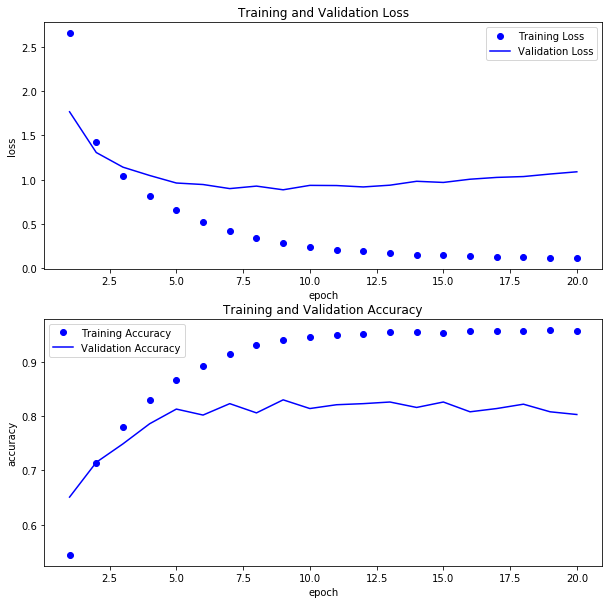

In [37]:
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 10))

plt.subplot(211)
plt.plot(epochs, loss, "bo", label="Training Loss")
plt.plot(epochs, val_loss, "b", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

plt.subplot(212)
plt.plot(epochs, acc, "bo", label="Training Accuracy")
plt.plot(epochs, val_acc, "b", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend();

In [39]:
test_loss, test_acc = model.evaluate(x_test, one_hot_test_labels)
print("Test Loss: {}".format(test_loss))
print("Test Accuracy: {}".format(test_acc))

2246/2246 [==============================] - 0s 103us/sample - loss: 1.2536 - accuracy: 0.7912
Test Loss: 1.2536303744396777
Test Accuracy: 0.7911843061447144


In [45]:
model = models.Sequential()
model.add(layers.Dense(64, activation="relu", input_shape=(10000,)))
model.add(layers.Dense(4, activation="relu"))
model.add(layers.Dense(46, activation="softmax"))

model.compile(
    optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=20,
    batch_size=512,
    validation_data=(x_val, y_val)
)

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 94us/sample - loss: 3.6601 - accuracy: 0.0154 - val_loss: 3.4686 - val_accuracy: 0.0220
Epoch 2/20
7982/7982 [==============================] - 0s 45us/sample - loss: 3.3237 - accuracy: 0.0322 - val_loss: 3.2069 - val_accuracy: 0.0330
Epoch 3/20
7982/7982 [==============================] - 0s 45us/sample - loss: 3.0214 - accuracy: 0.1421 - val_loss: 2.9193 - val_accuracy: 0.3640
Epoch 4/20
7982/7982 [==============================] - 0s 45us/sample - loss: 2.6665 - accuracy: 0.4762 - val_loss: 2.5660 - val_accuracy: 0.5520
Epoch 5/20
7982/7982 [==============================] - 0s 45us/sample - loss: 2.2512 - accuracy: 0.5928 - val_loss: 2.1833 - val_accuracy: 0.5940
Epoch 6/20
7982/7982 [==============================] - 0s 44us/sample - loss: 1.8535 - accuracy: 0.6323 - val_loss: 1.8765 - val_accuracy: 0.6060
Epoch 7/20
7982/7982 [==============================] - 0s 49us/sample

In [46]:
test_loss, test_acc = model.evaluate(x_test, one_hot_test_labels)
print("Test Loss: {}".format(test_loss))
print("Test Accuracy: {}".format(test_acc))

2246/2246 [==============================] - 0s 104us/sample - loss: 1.5060 - accuracy: 0.6772
Test Loss: 1.5059987023167598
Test Accuracy: 0.677203893661499


Random Guessing

In [43]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
float(np.sum(hits_array) / len(test_labels))

0.18655387355298308

# Generating Predictions on the Test Data

In [44]:
predictions = model.predict(x_test)

print("Prediction shape: {}".format(predictions[0].shape))
print("Total probability: {}".format(np.sum(predictions[0])))
print("Predicted class: {}".format(np.argmax(predictions[0])))
print("Prediction confidence: {}".format(np.max(predictions[0])))

Prediction shape: (46,)
Total probability: 0.9999999403953552
Predicted class: 3
Prediction confidence: 0.9899937510490417
